## Stock Prediction Project

# Data Collection

In [353]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import streamlit
tickers = ["RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", 
           "AAPL", "TSLA", "MSFT", "AMZN", "GOOG", "NVDA"]

# df = yf.download("RELIANCE.NS",period='5y',interval='1d',multi_level_index=False)
# df.head()

In [354]:
import yfinance as yf
import pandas as pd

# ✅ List of tickers you want to pretrain on
tickers = ["RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "AAPL", "TSLA"]

all_data = []

for ticker in tickers:
    print(f"Downloading data for {ticker}...")
    df = yf.download(
        ticker,
        period='5y',               # ✅ same as your original setup
        interval='1d',             # ✅ daily data
        multi_level_index=False    # ✅ keep single-level columns (important)
    )

    df['Ticker'] = ticker         # Add ticker name as a column
    df.reset_index(inplace=True)  # Reset index to get 'Date' as a column
    all_data.append(df)

# ✅ Combine all data into one dataframe
df = pd.concat(all_data, ignore_index=True)

print("✅ Combined dataset shape:", df.shape)



/var/folders/9_/bmn2css11wz6v68hwcbdk8000000gn/T/ipykernel_9732/2125272048.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed
/var/folders/9_/bmn2css11wz6v68hwcbdk8000000gn/T/ipykernel_9732/2125272048.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


[*********************100%***********************]  1 of 1 completed
/var/folders/9_/bmn2css11wz6v68hwcbdk8000000gn/T/ipykernel_9732/2125272048.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


[*********************100%***********************]  1 of 1 completed
/var/folders/9_/bmn2css11wz6v68hwcbdk8000000gn/T/ipykernel_9732/2125272048.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


[*********************100%***********************]  1 of 1 completed
/var/folders/9_/bmn2css11wz6v68hwcbdk8000000gn/T/ipykernel_9732/2125272048.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


[*********************100%***********************]  1 of 1 completed
/var/folders/9_/bmn2css11wz6v68hwcbdk8000000gn/T/ipykernel_9732/2125272048.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


[*********************100%***********************]  1 of 1 completed

✅ Combined dataset shape: (7468, 7)


In [355]:
df.head()

,Date,Close,High,Low,Open,Volume,Ticker
0,2020-09-25,998.319641,1003.352760,982.721649,992.561088,28374935,RELIANCE.NS
1,2020-09-28,1004.917114,1014.779282,1000.745556,1009.791498,19666849,RELIANCE.NS
2,2020-09-29,1017.975769,1026.568231,1004.916946,1008.884493,25842539,RELIANCE.NS
3,2020-09-30,1013.124084,1027.928517,1008.884463,1024.754528,24465159,RELIANCE.NS
4,2020-10-01,1008.997925,1026.477654,1003.896802,1026.477654,20783227,RELIANCE.NS


## Data Cleaning 
1. Handling missing values 
2. Handling duplicates 
3. Understand the datasets

In [356]:
df.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
Ticker    0
dtype: int64

In [357]:
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=0]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

Date 0.0 % missing values
Close 0.0 % missing values
High 0.0 % missing values
Low 0.0 % missing values
Open 0.0 % missing values
Volume 0.0 % missing values
Ticker 0.0 % missing values


# Feature Extraction 

### Creating new Features Target_Price for Regression Task
### Target_Direction for Classification task

In [358]:
df["Target_Price"] = df["Close"].shift(-1)
df = df.reset_index()

In [359]:
df.head()

,index,Date,Close,High,Low,Open,Volume,Ticker,Target_Price
0,0,2020-09-25,998.319641,1003.352760,982.721649,992.561088,28374935,RELIANCE.NS,1004.917114
1,1,2020-09-28,1004.917114,1014.779282,1000.745556,1009.791498,19666849,RELIANCE.NS,1017.975769
2,2,2020-09-29,1017.975769,1026.568231,1004.916946,1008.884493,25842539,RELIANCE.NS,1013.124084
3,3,2020-09-30,1013.124084,1027.928517,1008.884463,1024.754528,24465159,RELIANCE.NS,1008.997925
4,4,2020-10-01,1008.997925,1026.477654,1003.896802,1026.477654,20783227,RELIANCE.NS,1003.080566


In [360]:
# df["Price_Trend"] = (df["Target_Price"]>df["Close"]).astype(int)
df["Price_Trend"] = ((df["Target_Price"] - df["Close"]) / df["Close"] > 0.02).astype(int)  


## Function to add more Features for better data

In [361]:
def add_technical_indicators(df):

    data = df.copy()

    #--- Moving Averages ---
    for window in [10, 20, 50, 200]:
        data[f'MA_{window}'] = data['Close'].rolling(window=window).mean()

    #--- RSI (Relative Strength Index) ---
    delta = data['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(gain).rolling(14).mean()
    roll_down = pd.Series(loss).rolling(14).mean()
    RS = roll_up / (roll_down + 1e-9)
    data['RSI_14'] = 100 - (100 / (1 + RS))

    # --- MACD ---
    ema12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema12 - ema26
    data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # --- ATR (Average True Range) ---
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['ATR_14'] = tr.rolling(window=14).mean()

    # --- Volatility (Rolling Std Dev of Close) ---
    data['Volatility_20'] = data['Close'].rolling(window=20).std()

    # Drop initial NaN rows created by rolling calculations
    data = data.dropna().reset_index(drop=True)

    return data
df = add_technical_indicators(df)





In [362]:
# import ta

# def add_more_ta_features(df):
#     # MACD diff
#     macd = ta.trend.MACD(df['Close'])
#     df['MACD_diff'] = macd.macd_diff()

#     # Moving averages
#     df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()
#     df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
#     df['SMA_50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()
#     df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
#     df['EMA_20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

#     # Bollinger Bands
#     bb = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
#     df['BB_High'] = bb.bollinger_hband()
#     df['BB_Low'] = bb.bollinger_lband()
#     df['BB_Percent'] = bb.bollinger_pband()

#     # OBV
#     df['OBV'] = ta.volume.OnBalanceVolumeIndicator(
#         close=df['Close'], volume=df['Volume']
#     ).on_balance_volume()

#     return df

# # Apply to your dataframe
# df = add_more_ta_features(df)


In [363]:
df

,index,Date,Close,High,Low,Open,Volume,Ticker,Target_Price,Price_Trend,MA_10,MA_20,MA_50,MA_200,RSI_14,MACD,MACD_signal,ATR_14,Volatility_20
0,199,2021-07-15,947.494324,953.250205,945.742508,953.250205,9448356,RELIANCE.NS,961.167419,0,956.892572,968.365686,953.231390,926.684402,45.255490,-5.324321,-1.381049,13.370849,24.409337
1,200,2021-07-16,961.167419,962.236707,949.883126,949.951367,8828185,RELIANCE.NS,955.047485,0,956.134979,965.789185,954.943224,926.498640,55.398782,-4.612361,-2.027312,12.945088,22.093392
2,201,2021-07-19,955.047485,966.445513,951.998913,955.525231,8354449,RELIANCE.NS,952.704163,0,953.803040,962.642776,956.525858,926.249292,52.176477,-4.490195,-2.519888,13.167718,18.450789
3,202,2021-07-20,952.704163,959.165380,948.245098,955.297736,6741464,RELIANCE.NS,964.943970,0,952.392499,959.640833,958.111956,925.922934,46.466774,-4.530242,-2.921959,12.815085,14.284159
4,203,2021-07-22,964.943970,966.400015,954.683471,964.170453,7972397,RELIANCE.NS,958.118774,0,952.877081,957.714993,959.879822,925.682034,54.502266,-3.533597,-3.044287,12.878461,10.027508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7263,7462,2025-09-18,416.850006,432.220001,416.559998,428.869995,90454500,TSLA,426.070007,1,383.112000,361.047000,337.950999,332.360700,77.047550,22.429991,14.330543,15.874278,33.327681
7264,7463,2025-09-19,426.070007,429.470001,421.720001,421.820007,93131000,TSLA,434.209991,0,390.635001,366.345001,340.274999,332.765250,85.981898,23.996880,16.263810,15.557850,34.864193
7265,7464,2025-09-22,434.209991,444.980011,429.130005,431.109985,97108800,TSLA,425.850006,0,399.416000,371.055000,342.688999,333.150850,89.791283,25.600375,18.131123,16.317851,37.390662
7266,7465,2025-09-23,425.850006,440.970001,423.720001,439.880005,83422700,TSLA,442.790009,1,407.304001,375.017500,344.867999,333.523000,83.889809,25.898038,19.684506,16.491425,38.834052


In [364]:
# from sklearn.preprocessing import OneHotEncoder

# # encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Columns to encode
columns_to_encode = ['Ticker']

# Copy only the Ticker column
ticker_data = df[columns_to_encode].copy()

# Initialize encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on the original ticker column
ticker_encoded = encoder.fit_transform(ticker_data)

# Create a new DataFrame with proper column names
ticker_df = pd.DataFrame(
    ticker_encoded,
    columns=encoder.get_feature_names_out(columns_to_encode),
    index=df.index  # keep the original index to avoid misalignment
)

# Concatenate safely without touching other columns
df_encoded = pd.concat([df, ticker_df], axis=1)



In [365]:
X = df.drop(["Target_Price","Date","Price_Trend","Ticker"],axis = 1)
y = df["Target_Price"]


In [366]:
z = df["Price_Trend"]

In [367]:
X.head()

,index,Close,High,Low,Open,Volume,MA_10,MA_20,MA_50,MA_200,RSI_14,MACD,MACD_signal,ATR_14,Volatility_20
0,199,947.494324,953.250205,945.742508,953.250205,9448356,956.892572,968.365686,953.231390,926.684402,45.255490,-5.324321,-1.381049,13.370849,24.409337
1,200,961.167419,962.236707,949.883126,949.951367,8828185,956.134979,965.789185,954.943224,926.498640,55.398782,-4.612361,-2.027312,12.945088,22.093392
2,201,955.047485,966.445513,951.998913,955.525231,8354449,953.803040,962.642776,956.525858,926.249292,52.176477,-4.490195,-2.519888,13.167718,18.450789
3,202,952.704163,959.165380,948.245098,955.297736,6741464,952.392499,959.640833,958.111956,925.922934,46.466774,-4.530242,-2.921959,12.815085,14.284159
4,203,964.943970,966.400015,954.683471,964.170453,7972397,952.877081,957.714993,959.879822,925.682034,54.502266,-3.533597,-3.044287,12.878461,10.027508


In [368]:
df.isnull().sum()

index            0
Date             0
Close            0
High             0
Low              0
Open             0
Volume           0
Ticker           0
Target_Price     0
Price_Trend      0
MA_10            0
MA_20            0
MA_50            0
MA_200           0
RSI_14           0
MACD             0
MACD_signal      0
ATR_14           0
Volatility_20    0
dtype: int64

# Importing Libraries used 

In [369]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,\
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,mean_absolute_error,root_mean_squared_error

# Dividing the Featueres and Label in Training Set and Test Set

In [370]:
X_train,X_test,y_train,y_test,z_train,z_test = train_test_split(X,y,z,test_size=0.2,random_state=101)
# X_test.shape()
X_train
X_test

,index,Close,High,Low,Open,Volume,MA_10,MA_20,MA_50,MA_200,RSI_14,MACD,MACD_signal,ATR_14,Volatility_20
6989,7188,201.380005,208.440002,198.750000,207.389999,70250000,202.135001,217.525001,212.018200,203.046300,40.844254,-6.340843,-3.568173,11.698574,18.826012
3725,3924,651.677246,661.516962,645.561858,659.838730,20670342,673.122308,682.470071,682.466708,659.663855,22.201903,-6.629887,-2.069185,11.485166,16.564631
6538,6737,224.639999,230.600006,218.199997,219.399994,85012500,216.832001,227.616501,265.831735,279.654483,43.195800,-14.912235,-16.737427,13.588573,17.635735
3963,4162,647.392944,653.649162,646.276578,653.649162,9876974,637.999286,627.359024,625.073179,677.133314,75.444367,5.868907,2.566868,10.499041,15.656707
5003,5202,142.988968,145.690946,142.695273,145.690946,129868800,147.892644,147.522594,145.147601,130.838767,44.769315,0.322092,1.235638,3.039011,2.893767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,1006,1338.006104,1370.526246,1334.893535,1363.753247,15831960,1356.248279,1400.759241,1447.743135,1446.377971,23.363654,-32.809703,-30.187905,28.061135,59.872028
1658,1857,3003.485352,3015.668856,2979.789830,3002.765850,1123939,3080.246191,3155.261499,3238.297935,3122.019656,21.178358,-71.345678,-50.488517,62.103356,96.864806
2149,2348,3519.813232,3535.421114,3469.285439,3469.285439,2845192,3501.948315,3545.015588,3835.441055,4057.825514,44.475486,-105.640124,-117.940104,65.772301,98.202566
2275,2474,3073.800049,3106.899902,3065.000000,3095.000000,3634901,3126.709961,3112.224976,3103.021997,3535.984438,45.241105,7.543970,1.616136,48.357108,43.906325


# Checking the Performance of Raw models without hyperparameter Tuning 

In [371]:
models = {"Random Forest":RandomForestRegressor(),"Gradient Boosting":GradientBoostingRegressor(),
          "AdaBoosting":AdaBoostRegressor()}
for i in range(len(list(models))):
  model = list(models.values())[i]
  model.fit(X_train,y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  
  #Training set performance
  MAE_Score_Train = mean_absolute_error(y_train,y_train_pred)
  RMSE_Score_Train = root_mean_squared_error(y_train,y_train_pred)
  r2_Score_train = r2_score(y_train,y_train_pred)

  #Testing set Performance
  MAE_Score_test = mean_absolute_error(y_test,y_test_pred)
  RMSE_Score_test = root_mean_squared_error(y_test,y_test_pred)
  r2_Score_test = r2_score(y_test,y_test_pred)

  print(list(models.keys())[i])
  print("Training data Performance:")

  print("RMSE Score: {:.4f}".format(RMSE_Score_Train))
  print("MAE Score: {:.4f}".format(MAE_Score_Train))
  print("R2 Score: {:.4f}".format(r2_Score_train))
  
  print("\nTest data Performance:")

  print("RMSE Score: {:.4f}".format(RMSE_Score_test))
  print("MAE Score: {:.4f}".format(MAE_Score_test))
  print("R2 Score: {:.4f}".format(r2_Score_test))

     
  print('\n')
  print('='*35)
  print('\n')
  


Random Forest
Training data Performance:
RMSE Score: 16.1932
MAE Score: 5.7188
R2 Score: 0.9998

Test data Performance:
RMSE Score: 33.4327
MAE Score: 14.6143
R2 Score: 0.9991




Gradient Boosting
Training data Performance:
RMSE Score: 21.4029
MAE Score: 12.8298
R2 Score: 0.9996

Test data Performance:
RMSE Score: 33.4622
MAE Score: 15.2138
R2 Score: 0.9991




AdaBoosting
Training data Performance:
RMSE Score: 87.7951
MAE Score: 69.8559
R2 Score: 0.9938

Test data Performance:
RMSE Score: 88.8213
MAE Score: 68.1736
R2 Score: 0.9936






# Hyperparameter Tuning 

In [372]:
Param_Distribution_RF = {"n_estimators":[50,100,300,1000],
                         "max_depth":[2,5,10],
                         "min_samples_split":[2,5,10],
                         "min_samples_leaf":[1,2,4],
                         "bootstrap":[True,False],
                         "max_features":[2,5,10]}
Param_distribution_ADA = {"n_estimators":[50,100,300,1000],
                          "learning_rate":[0.1,0.01,1.0],
                          "loss":["square","linear","exponential"],
                          }
Param_distribution_GB = {"n_estimators":[50,100,300,1000],
                         "learning_rate":[0.1,1.0,0.01],
                         "loss":['squared_error', 'absolute_error', 'huber', 'quantile'],
                         "max_depth":[2,5,10],
                         "min_samples_split":[2,5,10],
                         "min_samples_leaf":[1,2,4],
                         "max_features":[2,5,10],
                         "subsample":[0.01,0.05,0.1,0.5]}

In [373]:
randomCV_model_list = [("RF",RandomForestRegressor(),Param_Distribution_RF),
                       ("ADA",AdaBoostRegressor(),Param_distribution_ADA),
                       ("GB",GradientBoostingRegressor(),Param_distribution_GB)]

In [374]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomCV_model_list:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=2, max_features=2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=2, max_features=2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=2, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=2, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] E

/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   1.1s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   1.1s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   1.1s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=100; total time=   1.8s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=100; total time=   1.9s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=100; total time=   1.9s
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time=   1.0s
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time=   1.0s
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time=   1.0s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=300; total time=   4.1s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=300; total time=   4.3s
[CV] END ...learning_rate=0.1, loss=linear, n_e

# Best performing Model

In [375]:
models={
    
    "Random Forest":RandomForestRegressor(n_estimators= 100, min_samples_split= 2, min_samples_leaf= 1, 
                                           max_features= 5, max_depth= 10, bootstrap= True),
    "Adaboost":AdaBoostRegressor(n_estimators= 1000,loss= 'exponential', learning_rate= 1.0),
    "GradientBoosting":GradientBoostingRegressor(n_estimators= 1000, min_samples_split =2, min_samples_leaf= 1,
                                                  max_features = 5, max_depth = 10, loss = 'squared_error', learning_rate= 0.01,subsample=0.5)
}

for i in range(len(list(models))):
  model = list(models.values())[i]
  model.fit(X_train,y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  
  #Training set performance
  MAE_Score_Train = mean_absolute_error(y_train,y_train_pred)
  RMSE_Score_Train = root_mean_squared_error(y_train,y_train_pred)
  r2_Score_train = r2_score(y_train,y_train_pred)

  #Testing set Performance
  MAE_Score_test = mean_absolute_error(y_test,y_test_pred)
  RMSE_Score_test = root_mean_squared_error(y_test,y_test_pred)
  r2_Score_test = r2_score(y_test,y_test_pred)

  print(list(models.keys())[i])
  print("Training data Performance:")

  print("RMSE Score: {:.4f}".format(RMSE_Score_Train))
  print("MAE Score: {:.4f}".format(MAE_Score_Train))
  print("R2 Score: {:.4f}".format(r2_Score_train))
  
  print("\nTest data Performance:")

  print("RMSE Score: {:.4f}".format(RMSE_Score_test))
  print("MAE Score: {:.4f}".format(MAE_Score_test))
  print("R2 Score: {:.4f}".format(r2_Score_test))

     
  print('\n')
  print('='*35)
  print('\n')

  
  

Random Forest
Training data Performance:
RMSE Score: 18.6098
MAE Score: 8.9437
R2 Score: 0.9997

Test data Performance:
RMSE Score: 32.4138
MAE Score: 14.2683
R2 Score: 0.9991




Adaboost
Training data Performance:
RMSE Score: 82.5826
MAE Score: 65.1348
R2 Score: 0.9945

Test data Performance:
RMSE Score: 85.2000
MAE Score: 64.8775
R2 Score: 0.9941




GradientBoosting
Training data Performance:
RMSE Score: 4.2252
MAE Score: 3.2892
R2 Score: 1.0000

Test data Performance:
RMSE Score: 32.6341
MAE Score: 14.3558
R2 Score: 0.9991






Random Forest
Training data Performance:
RMSE Score: 15.5112
MAE Score: 11.4090
R2 Score: 0.9887

Test data Performance:
RMSE Score: 17.3330
MAE Score: 12.8323
R2 Score: 0.9876


===================================


Adaboost
Training data Performance:
RMSE Score: 18.8938
MAE Score: 15.1647
R2 Score: 0.9832

Test data Performance:
RMSE Score: 20.8096
MAE Score: 15.5778
R2 Score: 0.9821


===================================


GradientBoosting
Training data Performance:
RMSE Score: 15.0636
MAE Score: 10.8742
R2 Score: 0.9893

Test data Performance:
RMSE Score: 17.5005
MAE Score: 12.9929
R2 Score: 0.9873


In [376]:
# from sklearn.model_selection import GridSearchCV
# model1 = RandomForestRegressor()
# Param_grid = {"n_estimators":[900,1000,1050],
#                          "max_depth":[4,5,6],
#                          "min_samples_split":[9,10,12],
#                          "min_samples_leaf":[3,4,5],
#                          "max_features":[9,10,11]}
# grid_model = GridSearchCV(model1,Param_grid,cv=5,verbose=2,n_jobs=-1)
# grid_model.fit(X_train,y_train)


In [377]:
# grid_model.best_params_

# Final Best performing model

In [378]:
Final_Model = RandomForestRegressor(n_estimators= 100, min_samples_split= 2, min_samples_leaf= 1, 
                                           max_features= 5, max_depth= 10, bootstrap= True)
Final_Model.fit(X_train,y_train)

y_test_pred = Final_Model.predict(X_test)

MAE_Score_test = mean_absolute_error(y_test,y_test_pred)
RMSE_Score_test = root_mean_squared_error(y_test,y_test_pred)
r2_Score_test = r2_score(y_test,y_test_pred)

print("RMSE Score: {:.4f}".format(RMSE_Score_test))
print("MAE Score: {:.4f}".format(MAE_Score_test))
print("R2 Score: {:.4f}".format(r2_Score_test))


RMSE Score: 32.5034
MAE Score: 14.3047
R2 Score: 0.9991


In [379]:
def plot_prices(y_test,y_pred):
  plt.figure(figsize=(15,10),dpi = 700)
  plt.plot(y_test.values, label='Actual Price', color='blue')
  plt.plot(y_pred, label='price_prediction', color='red')

  plt.title('Actual vs Predicted Stock Prices')
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.xlim(pd.to_datetime("2023-01-01"), pd.to_datetime("2023-06-01"))

  plt.legend()
  plt.show()

# RESULTS 

In [380]:
plot_prices(y_test,y_test_pred)

In [381]:
import joblib
joblib.dump(Final_Model,"Saved_Final_model.joblib")

['Saved_Final_model.joblib']

# Classification Task 

In [382]:
models = {"Random Forest":RandomForestClassifier(),"Gradient Boosting":GradientBoostingClassifier(),
          "AdaBoosting":AdaBoostClassifier()}
for i in range(len(list(models))):
  model = list(models.values())[i]
  model.fit(X_train,z_train)

  z_train_pred = model.predict(X_train)
  z_test_pred = model.predict(X_test)
  
 
  # # Training set performance
  # model_train_accuracy = accuracy_score(z_train, z_train_pred) # Calculate Accuracy
  # model_train_f1 = f1_score(z_train, z_train_pred, average='weighted') # Calculate F1-score
  # model_train_precision = precision_score(z_train, z_train_pred) # Calculate Precision
  # model_train_recall = recall_score(z_train, z_train_pred) # Calculate Recall
  # model_train_rocauc_score = roc_auc_score(z_train, z_train_pred)


  #   # Test set performance
  # model_test_accuracy = accuracy_score(z_test, z_test_pred) # Calculate Accuracy
  # model_test_f1 = f1_score(z_test, z_test_pred, average='weighted') # Calculate F1-score
  # model_test_precision = precision_score(z_test, z_test_pred) # Calculate Precision
  # model_test_recall = recall_score(z_test, z_test_pred) # Calculate Recall
  # model_test_rocauc_score = roc_auc_score(z_test, z_test_pred) #Calculate Roc

  print(list(models.keys())[i])
    
  print('\nModel performance for Training set')
  print(classification_report(z_train,z_train_pred))
  # print("- Accuracy: {:.4f}".format(model_train_accuracy))
  # print('- F1 score: {:.4f}'.format(model_train_f1))
    
  # print('- Precision: {:.4f}'.format(model_train_precision))
  # print('- Recall: {:.4f}'.format(model_train_recall))
  # print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
  print('----------------------------------')
    
  print('Model performance for Test set')
  print(classification_report(z_test,z_test_pred))
  # print('- Accuracy: {:.4f}'.format(model_test_accuracy))
  # print('- F1 score: {:.4f}'.format(model_test_f1))
  # print('- Precision: {:.4f}'.format(model_test_precision))
  # print('- Recall: {:.4f}'.format(model_test_recall))
  # print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

     
  print('\n')
  print('='*35)
  print('\n')
  


Random Forest

Model performance for Training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5157
           1       1.00      1.00      1.00       657

    accuracy                           1.00      5814
   macro avg       1.00      1.00      1.00      5814
weighted avg       1.00      1.00      1.00      5814

----------------------------------
Model performance for Test set
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1291
           1       0.21      0.04      0.07       163

    accuracy                           0.87      1454
   macro avg       0.55      0.51      0.50      1454
weighted avg       0.81      0.87      0.84      1454





Gradient Boosting

Model performance for Training set
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      5157
           1       0.93      0.13      0.22       657

    accu

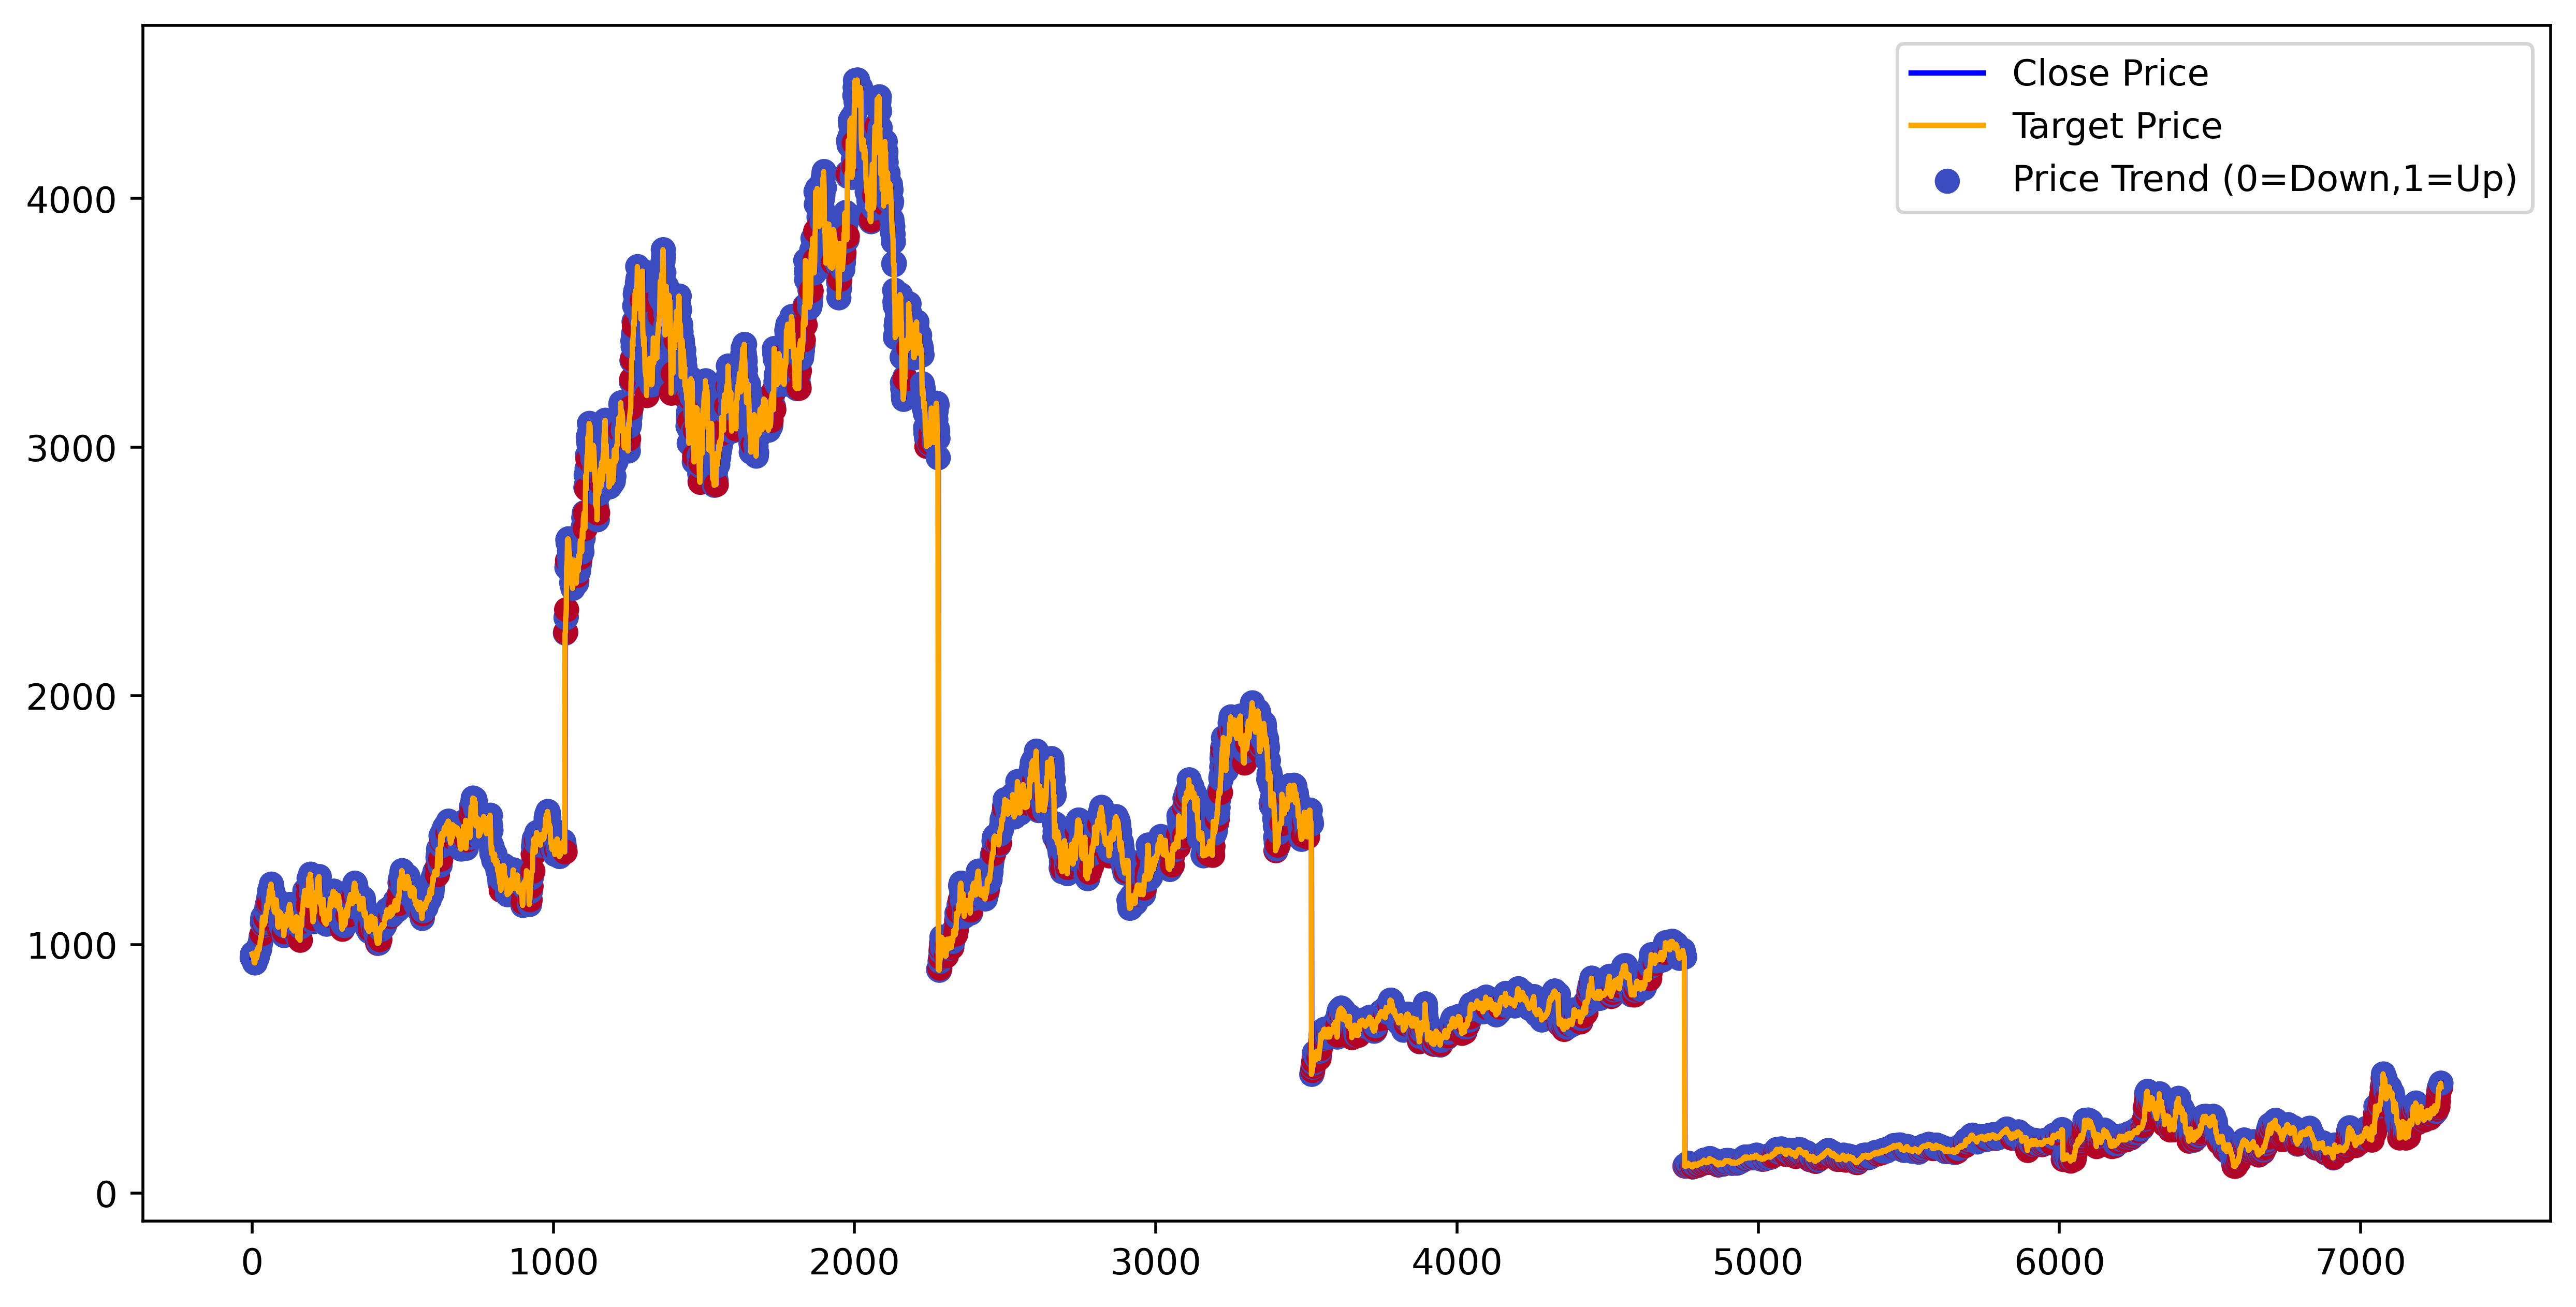

In [383]:

plt.figure(figsize=(12,6),dpi = 500)
plt.plot(df.index, df["Close"], label="Close Price", color="blue")
plt.plot(df.index, df["Target_Price"], label="Target Price", color="orange")
plt.scatter(df.index, df["Close"], c=df["Price_Trend"], cmap="coolwarm", label="Price Trend (0=Down,1=Up)")
plt.legend()
plt.show()


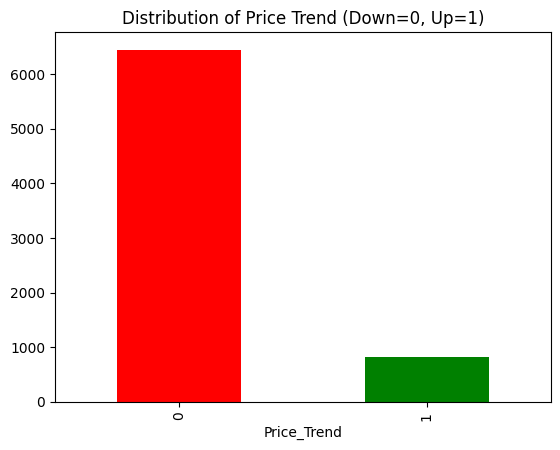

In [384]:
df["Price_Trend"].value_counts().plot(kind="bar", color=["red","green"])
plt.title("Distribution of Price Trend (Down=0, Up=1)")
plt.show()



In [385]:
# plt.figure(figsize=(10,6))
# sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
# plt.title("Feature Correlation")
# plt.show()

In [386]:
Param_Distribution_RF = {"n_estimators":[50,100,300,1000],
                         "max_depth":[2,5,10],
                         "min_samples_split":[2,5,10],
                         "min_samples_leaf":[1,2,4],
                         "bootstrap":[True,False],
                         "max_features":[2,5,10]}
Param_distribution_ADA = {"n_estimators":[50,100,300,1000],
                          "learning_rate":[0.1,0.01,1.0],
                          "algorithm":["SAMME","SAMME.R"]
                          }
Param_distribution_GB = {"n_estimators":[50,100,300,1000],
                         "learning_rate":[0.1,1.0,0.01],
                         "loss":['log_loss', 'exponential'],
                         "max_depth":[2,5,10],
                         "min_samples_split":[2,5,10],
                         "min_samples_leaf":[1,2,4],
                         "max_features":[2,5,10],
                         "subsample":[0.01,0.05,0.1,0.5]}

In [387]:
Classifier_RandomSearched_model = [("RF",RandomForestClassifier(class_weight="balanced"),Param_Distribution_RF),
                        ("ADA",AdaBoostClassifier(),Param_distribution_ADA),
                        ("GB",GradientBoostingClassifier(),Param_distribution_GB)]

In [388]:
model_param1 = {}
for name, model, param in Classifier_RandomSearched_model:
  random_model = RandomizedSearchCV(estimator=model,
                                    param_distributions=param,
                                    cv = 3,
                                    n_iter=100,
                                    n_jobs=-1,
                                    verbose=2
                                    )
  random_model.fit(X_train,z_train)
  model_param1[name] = random_model.best_params_

  for model_name in model_param1:
    print(f"---------------Best parameter of {model_name}------------")
    print(model_param1[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=2, max_features=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=2, max_features=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=2, max_features=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=True, max_depth=5, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.3s
[CV] EN

/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 a

[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=50; total time=   0.4s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=50; total time=   0.4s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=50; total time=   0.5s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=100; total time=   0.9s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=100; total time=   0.9s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=100; total time=   0.9s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=50; total time=   0.4s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=50; total time=   0.4s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=50; total time=   0.5s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=100; total time=   0.9s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=100; total time=   0.9s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=300; total time=   2.7s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=300; total time=   2.7s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=300; total time=   2.7s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=100; total time=   0.9s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=300; total time=   2.8s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=300; total time=   2.9s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=300; total time=   2.9s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=1.0, n_estimators=50; total time=   0.4s
[CV] END algorithm=SAMME, learning_rate=1.0, n_estimators=50; total time=   0.5s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=1.0, n_estimators=50; total time=   0.5s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=1.0, n_estimators=100; total time=   0.9s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=1.0, n_estimators=100; total time=   0.9s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=1.0, n_estimators=100; total time=   0.9s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=1000; total time=   9.3s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=1000; total time=   9.5s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=1000; total time=   9.4s
[CV] END algorithm=SAMME, learning_rate=1.0, n_estimators=300; total time=   2.8s


/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[CV] END algorithm=SAMME, learning_rate=1.0, n_estimators=300; total time=   2.9s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=50; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=100; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=100; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=100; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=300; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=300; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=300; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=1000; total time=   0.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=1000; total time=   

/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/base.py", line 1356, in wrapper
    estimator._validate_params()
    

---------------Best parameter of RF------------
{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 10, 'bootstrap': True}
---------------Best parameter of ADA------------
{'n_estimators': 100, 'learning_rate': 1.0, 'algorithm': 'SAMME'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learning_rate=0.01, loss=exponential, max_depth=2, max_features=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50, subsample=0.05; total time=   0.1s
[CV] END learning_rate=0.01, loss=exponential, max_depth=2, max_features=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50, subsample=0.05; total time=   0.1s
[CV] END learning_rate=0.01, loss=exponential, max_depth=2, max_features=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50, subsample=0.05; total time=   0.1s
[CV] END learning_rate=0.01, loss=exponential, max_depth=5, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100, s

In [389]:
models={"Random Forest":RandomForestClassifier(n_estimators= 100, min_samples_split= 2, min_samples_leaf= 2, 
                                           max_features= 10, max_depth= 10, bootstrap= True),
    "Adaboost":AdaBoostClassifier(n_estimators= 100,algorithm = "SAMME", learning_rate= 1.0),
    "GradientBoosting":GradientBoostingClassifier(n_estimators= 300, min_samples_split =10, min_samples_leaf= 1,subsample=0.5,
                                                  max_features = 10, max_depth = 5, loss = 'exponential', learning_rate= 0.01)
}
for i in range(len(list(models))):
  model = list(models.values())[i]
  model.fit(X_train,z_train)

  z_train_pred = model.predict(X_train)
  z_test_pred = model.predict(X_test)
  
 
  # # Training set performance
  # model_train_accuracy = accuracy_score(z_train, z_train_pred) # Calculate Accuracy
  # model_train_f1 = f1_score(z_train, z_train_pred, average='weighted') # Calculate F1-score
  # model_train_precision = precision_score(z_train, z_train_pred) # Calculate Precision
  # model_train_recall = recall_score(z_train, z_train_pred) # Calculate Recall
  # model_train_rocauc_score = roc_auc_score(z_train, z_train_pred)


  #   # Test set performance
  # model_test_accuracy = accuracy_score(z_test, z_test_pred) # Calculate Accuracy
  # model_test_f1 = f1_score(z_test, z_test_pred, average='weighted') # Calculate F1-score
  # model_test_precision = precision_score(z_test, z_test_pred) # Calculate Precision
  # model_test_recall = recall_score(z_test, z_test_pred) # Calculate Recall
  # model_test_rocauc_score = roc_auc_score(z_test, z_test_pred) #Calculate Roc

  print(list(models.keys())[i])
    
  print('\nModel performance for Training set')
  print(classification_report(z_train,z_train_pred))
  # print("- Accuracy: {:.4f}".format(model_train_accuracy))
  # print('- F1 score: {:.4f}'.format(model_train_f1))
    
  # print('- Precision: {:.4f}'.format(model_train_precision))
  # print('- Recall: {:.4f}'.format(model_train_recall))
  # print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
  print('----------------------------------')
    
  print('Model performance for Test set')
  print(classification_report(z_test,z_test_pred))
  # print('- Accuracy: {:.4f}'.format(model_test_accuracy))
  # print('- F1 score: {:.4f}'.format(model_test_f1))
  # print('- Precision: {:.4f}'.format(model_test_precision))
  # print('- Recall: {:.4f}'.format(model_test_recall))
  # print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

     
  print('\n')
  print('='*35)
  print('\n')
  


Random Forest

Model performance for Training set
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5157
           1       1.00      0.25      0.41       657

    accuracy                           0.92      5814
   macro avg       0.96      0.63      0.68      5814
weighted avg       0.92      0.92      0.89      5814

----------------------------------
Model performance for Test set
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1291
           1       0.15      0.02      0.04       163

    accuracy                           0.87      1454
   macro avg       0.52      0.50      0.49      1454
weighted avg       0.81      0.87      0.83      1454







/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Adaboost

Model performance for Training set
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5157
           1       0.73      0.01      0.02       657

    accuracy                           0.89      5814
   macro avg       0.81      0.51      0.48      5814
weighted avg       0.87      0.89      0.84      5814

----------------------------------
Model performance for Test set
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1291
           1       0.25      0.01      0.01       163

    accuracy                           0.89      1454
   macro avg       0.57      0.50      0.48      1454
weighted avg       0.82      0.89      0.84      1454





GradientBoosting

Model performance for Training set
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5157
           1       0.96      0.04      0.07       657

    accuracy  

In [390]:
final_model_classification = RandomForestClassifier(n_estimators= 1000, min_samples_split= 2, min_samples_leaf= 2, 
                                           max_features= 2, max_depth= 10, bootstrap= True,class_weight="balanced")
final_model_classification.fit(X_train,z_train)
y_pred_final = final_model_classification.predict(X_test)

feature_imp = final_model_classification.feature_importances_
feature_imp

array([0.08702787, 0.06508256, 0.06310044, 0.07201957, 0.06702567,
       0.09358641, 0.06112153, 0.06337249, 0.06062571, 0.06142834,
       0.05504074, 0.05895055, 0.05643129, 0.0739456 , 0.06124124])

In [391]:
# predicted_values = pd.DataFrame(data=y_pred_final,columns=["price_trend_pred"])
predicted_values = X_test
predicted_values["price_trend_pred"] = y_pred_final
predicted_values

,index,Close,High,Low,Open,Volume,MA_10,MA_20,MA_50,MA_200,RSI_14,MACD,MACD_signal,ATR_14,Volatility_20,price_trend_pred
6989,7188,201.380005,208.440002,198.750000,207.389999,70250000,202.135001,217.525001,212.018200,203.046300,40.844254,-6.340843,-3.568173,11.698574,18.826012,1
3725,3924,651.677246,661.516962,645.561858,659.838730,20670342,673.122308,682.470071,682.466708,659.663855,22.201903,-6.629887,-2.069185,11.485166,16.564631,0
6538,6737,224.639999,230.600006,218.199997,219.399994,85012500,216.832001,227.616501,265.831735,279.654483,43.195800,-14.912235,-16.737427,13.588573,17.635735,1
3963,4162,647.392944,653.649162,646.276578,653.649162,9876974,637.999286,627.359024,625.073179,677.133314,75.444367,5.868907,2.566868,10.499041,15.656707,0
5003,5202,142.988968,145.690946,142.695273,145.690946,129868800,147.892644,147.522594,145.147601,130.838767,44.769315,0.322092,1.235638,3.039011,2.893767,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,1006,1338.006104,1370.526246,1334.893535,1363.753247,15831960,1356.248279,1400.759241,1447.743135,1446.377971,23.363654,-32.809703,-30.187905,28.061135,59.872028,0
1658,1857,3003.485352,3015.668856,2979.789830,3002.765850,1123939,3080.246191,3155.261499,3238.297935,3122.019656,21.178358,-71.345678,-50.488517,62.103356,96.864806,0
2149,2348,3519.813232,3535.421114,3469.285439,3469.285439,2845192,3501.948315,3545.015588,3835.441055,4057.825514,44.475486,-105.640124,-117.940104,65.772301,98.202566,0
2275,2474,3073.800049,3106.899902,3065.000000,3095.000000,3634901,3126.709961,3112.224976,3103.021997,3535.984438,45.241105,7.543970,1.616136,48.357108,43.906325,0


In [392]:
df.columns

Index(['index', 'Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker',
       'Target_Price', 'Price_Trend', 'MA_10', 'MA_20', 'MA_50', 'MA_200',
       'RSI_14', 'MACD', 'MACD_signal', 'ATR_14', 'Volatility_20'],
      dtype='object')

In [393]:
pd.DataFrame(index=X.columns,data=feature_imp,columns=["Importance"]).sort_values(by="Importance")

,Importance
RSI_14,0.055041
MACD_signal,0.056431
MACD,0.058951
MA_50,0.060626
MA_10,0.061122
Volatility_20,0.061241
MA_200,0.061428
High,0.063100
MA_20,0.063372
Close,0.065083


In [394]:
print(classification_report(z_test,y_pred_final))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1291
           1       0.27      0.33      0.30       163

    accuracy                           0.83      1454
   macro avg       0.59      0.61      0.60      1454
weighted avg       0.84      0.83      0.83      1454



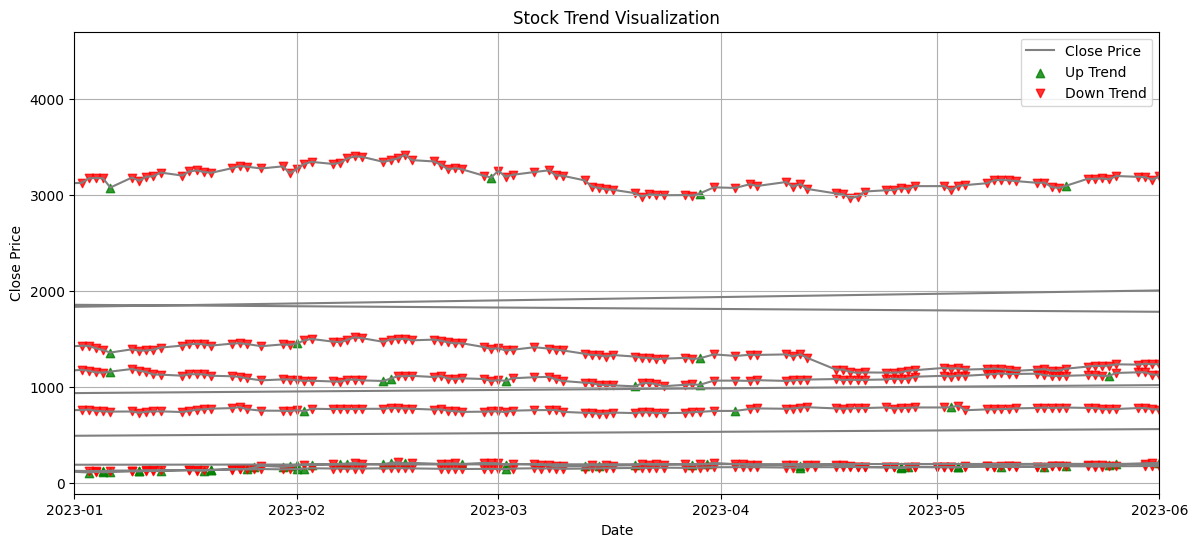

In [395]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], color='gray', label='Close Price')

# Highlight up and down trends
up = df[df['Price_Trend'] == 1]
down = df[df['Price_Trend'] == 0]

plt.scatter(up['Date'], up['Close'], color='green', label='Up Trend', marker='^', alpha=0.8)
plt.scatter(down['Date'], down['Close'], color='red', label='Down Trend', marker='v', alpha=0.8)

plt.title('Stock Trend Visualization')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xlim(pd.to_datetime("2023-01-01"), pd.to_datetime("2023-06-01"))
plt.legend()
plt.grid(True)
plt.show()



/var/folders/9_/bmn2css11wz6v68hwcbdk8000000gn/T/ipykernel_9732/1496763165.py:71: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/rahuljangra/Downloads/CodeWithRahul01/studysession/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


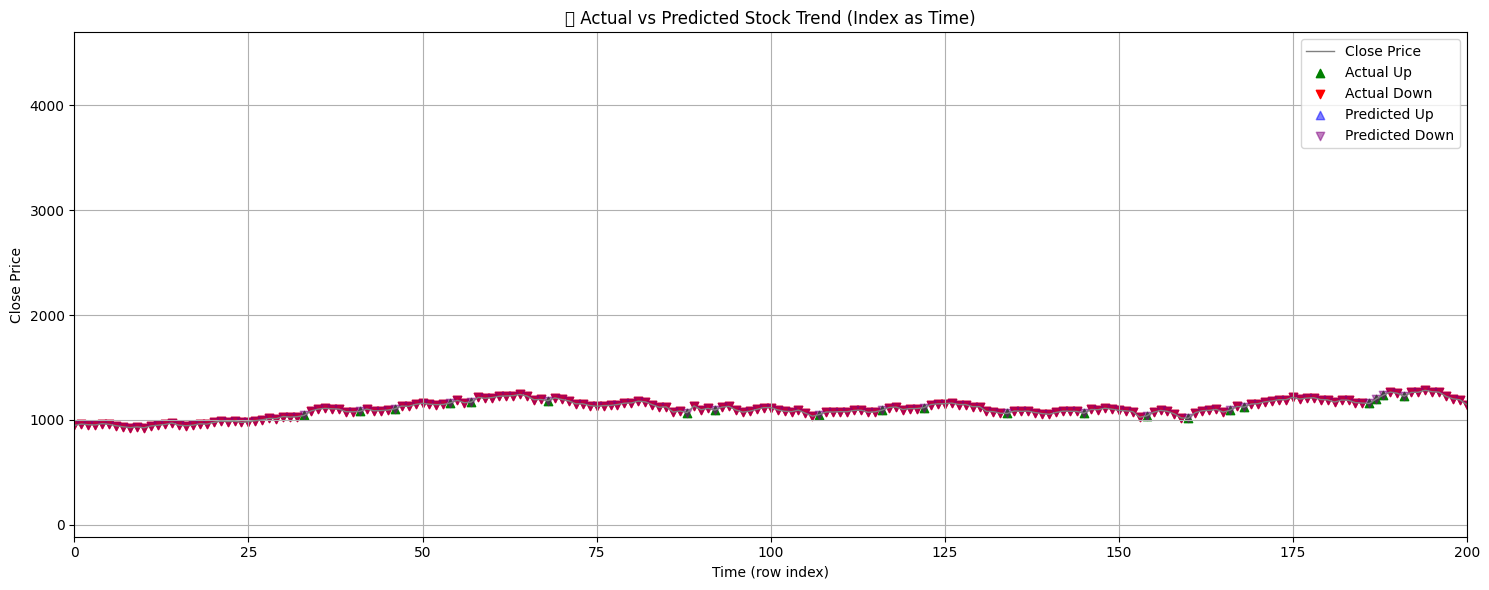

In [396]:
# import matplotlib.pyplot as plt
# import pandas as pd

# plt.figure(figsize=(14,6))
# plt.plot(df['Date'], df['Close'], color='gray', label='Close Price', linewidth=1.5)

# # --- Actual Trend ---
# actual_up = df[df['Price_Trend'] == 1]
# actual_down = df[df['Price_Trend'] == 0]

# plt.scatter(actual_up['Date'], actual_up['Close'], color='green', label='Actual Up', marker='^', alpha=0.7)
# plt.scatter(actual_down['Date'], actual_down['Close'], color='red', label='Actual Down', marker='v', alpha=0.7)

# # --- Predicted Trend ---
# pred_up = predicted_values[predicted_values["price_trend_pred"] == 1]
# pred_down = predicted_values[predicted_values["price_trend_pred"] == 0]
# # pred_down = df[df['Predicted_Trend'] == 0]

# plt.scatter(pred_up['Date'], pred_up['Close'], color='blue', label='Predicted Up', marker='^', alpha=0.4)
# plt.scatter(pred_down['Date'], pred_down['Close'], color='orange', label='Predicted Down', marker='v', alpha=0.4)

# plt.title("Actual vs Predicted Price Trends")
# plt.xlabel("Date")
# plt.ylabel("Close Price")
# plt.xlim(pd.to_datetime("2023-01-01"), pd.to_datetime("2023-06-01"))

# plt.xticks(rotation=45)
# plt.legend()
# plt.grid(True)
# plt.show()

import matplotlib.pyplot as plt
import pandas as pd

# If 'Date' column is missing, use index as "Time"
df = df.reset_index(drop=True)
df['Time'] = df.index


# Add predictions back to df if not already there
df['Predicted_Trend'] = model.predict(X)  # or your predicted series

# Separate actual trends
actual_up = df[df['Price_Trend'] == 1]
actual_down = df[df['Price_Trend'] == 0]

# Separate predicted trends
pred_up = df[df['Predicted_Trend'] == 1]
pred_down = df[df['Predicted_Trend'] == 0]
# pred_up = predicted_values[predicted_values["price_trend_pred"]==1]
# pred_down = predicted_values[predicted_values["price_trend_pred"]==0]

plt.figure(figsize=(15,6))

# Plot close price line
plt.plot(df['Time'], df['Close'], color='gray', label='Close Price', linewidth=1)

# ✅ Actual trend points
plt.scatter(actual_up['Time'], actual_up['Close'], color='green', label='Actual Up', marker='^')
plt.scatter(actual_down['Time'], actual_down['Close'], color='red', label='Actual Down', marker='v')

# ✅ Predicted trend points
plt.scatter(pred_up['Time'], pred_up['Close'], color='blue', label='Predicted Up', marker='^', alpha=0.5)
plt.scatter(pred_down['Time'], pred_down['Close'], color='purple', label='Predicted Down', marker='v', alpha=0.5)
plt.title('📈 Actual vs Predicted Stock Trend (Index as Time)')
plt.xlabel('Time (row index)')
plt.ylabel('Close Price')
plt.xlim(0,200)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [406]:
import joblib

# Save models
joblib.dump(Final_Model, "stock_price_regressor.joblib")
joblib.dump(final_model_classification, "stock_trend_classifier.joblib")

['stock_trend_classifier.joblib']

In [398]:
df.columns

Index(['index', 'Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker',
       'Target_Price', 'Price_Trend', 'MA_10', 'MA_20', 'MA_50', 'MA_200',
       'RSI_14', 'MACD', 'MACD_signal', 'ATR_14', 'Volatility_20', 'Time',
       'Predicted_Trend'],
      dtype='object')

In [403]:
X.columns


Index(['index', 'Close', 'High', 'Low', 'Open', 'Volume', 'MA_10', 'MA_20',
       'MA_50', 'MA_200', 'RSI_14', 'MACD', 'MACD_signal', 'ATR_14',
       'Volatility_20'],
      dtype='object')